In [10]:
import jax.random as jr
import jax.numpy as jnp
from jax.scipy.stats import multivariate_normal


from dynamax.linear_gaussian_ssm import lgssm_filter
from dynamax.linear_gaussian_ssm import LinearGaussianSSM as dmax_LGSSM

import matplotlib.pyplot as plt

from feynman_kac.protocol import FeynmacKac, PFConfig
from feynman_kac.bootstrap import BootstrapParticleFilter
from utils.datasets import load_dataset



In [11]:

class LGSSMModel(FeynmacKac):
    def __init__(self, params):
        self.params = params

    def p0(self, key, N):
        m1 = self.params['m1']
        Q1 = self.params['Q1']
        return jr.multivariate_normal(key, m1, Q1, shape=(N, ))

    def pt(self, key, x_prev, t):
        A = self.params['A']
        b = self.params['b']
        Q = self.params['Q']
        mean = A @ x_prev + b
        return jr.multivariate_normal(key, mean, Q)

    def log_g(self, t, x_t, x_prev, y_t):
        C = self.params['C'][0]
        R = self.params['R']
        mean = C @ x_t
        return multivariate_normal.logpdf(y_t, mean=mean, cov=R)
    
    def log_pt(self, t, x_t, x_prev):
        A = self.params['A']
        b = self.params['b']
        mean = A @ x_prev + b
        return multivariate_normal.logpdf(x_t, mean=mean, cov=self.params['Q'])
    

In [12]:

def exact_filter(data):
    
    # get true filter means using Kalman filter
    dmax_lgssm = dmax_LGSSM(data.train_states.shape[-1], data.train_data[0].shape[-1])
    params, _ = dmax_lgssm.initialize(
        jr.PRNGKey(0),
        initial_mean=data.params['m1'],
        initial_covariance=data.params['Q1'],
        dynamics_weights=data.params['A'],
        dynamics_covariance=data.params['Q'],
        emission_weights=data.params['C'],
        emission_covariance=data.params['R']
    )
    x, y = data.train_states[0], data.train_data[0][0]
    lgssm_posterior = lgssm_filter(params, y)
    print("Exact filter means shape: ", lgssm_posterior.filtered_means.shape)
    return lgssm_posterior


def bpf(data, N: int):

    # parametrise model with the true parameters for now
    lgssm = LGSSMModel(data.params)
    
    # construct bootstrap particle filter
    bpf = BootstrapParticleFilter(
        model=lgssm,
        config=PFConfig(
            N=N,
            resample_scheme='multinomial',
            ess_threshold=0.5,
            key=jr.PRNGKey(42)
        )
    )

    # run filter
    outs = bpf.filter(
        T=data.train_data[0].shape[1],
        obs=data.train_data[0][0]  # just using the first sequence
    )
    print("BPF particles shape: ", outs.particles.shape)
    print("BPF weights shape: ", outs.weights.shape)
    print("BPF logZ_hat: ", outs.logZ_hat)
    return outs



In [13]:
data = load_dataset('linear_small', seed=0)
lgssm_posterior = exact_filter(data)
x, y = data.train_states[0], data.train_data[0][0]

Exact filter means shape:  (300, 1)


N: 3                                                                                                   
BPF particles shape:  (300, 3, 1)
BPF weights shape:  (300, 3)
BPF logZ_hat:  -2021.2713623046875
BPF weighted x_t shape:  (300, 1)
MSE from BPF to exact filter means:  0.6090238


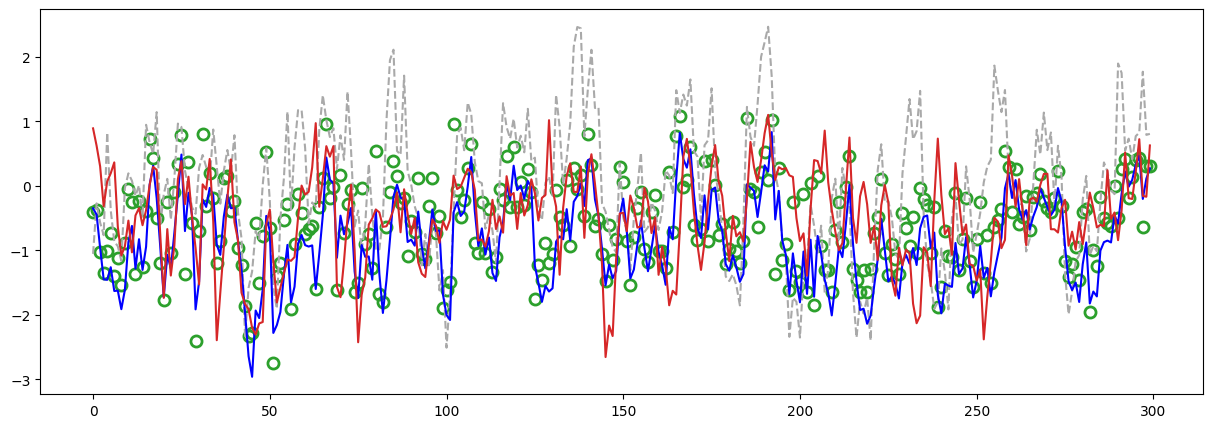




N: 10                                                                                                  
BPF particles shape:  (300, 10, 1)
BPF weights shape:  (300, 10)
BPF logZ_hat:  -832.7335205078125
BPF weighted x_t shape:  (300, 1)
MSE from BPF to exact filter means:  0.16013598


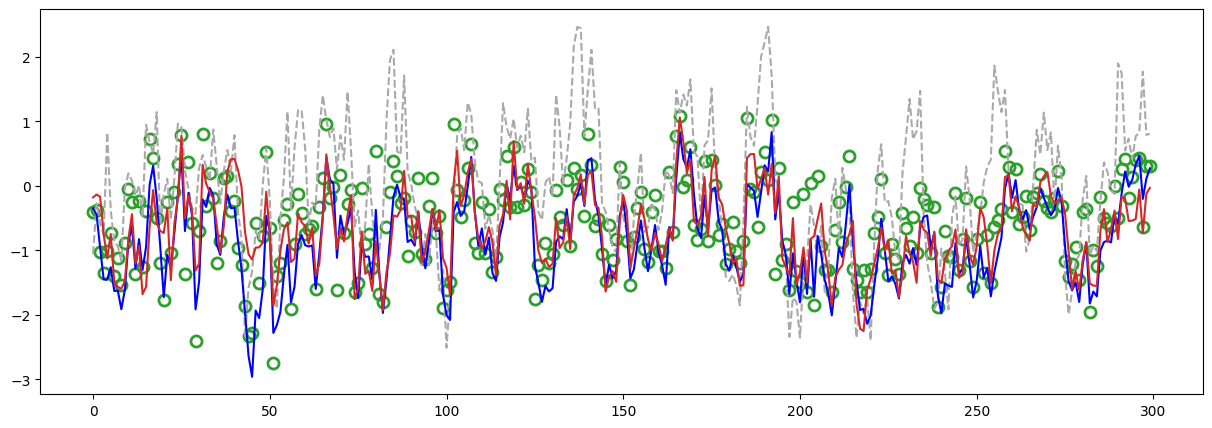




N: 50                                                                                                  
BPF particles shape:  (300, 50, 1)
BPF weights shape:  (300, 50)
BPF logZ_hat:  -751.8474731445312
BPF weighted x_t shape:  (300, 1)
MSE from BPF to exact filter means:  0.03162202


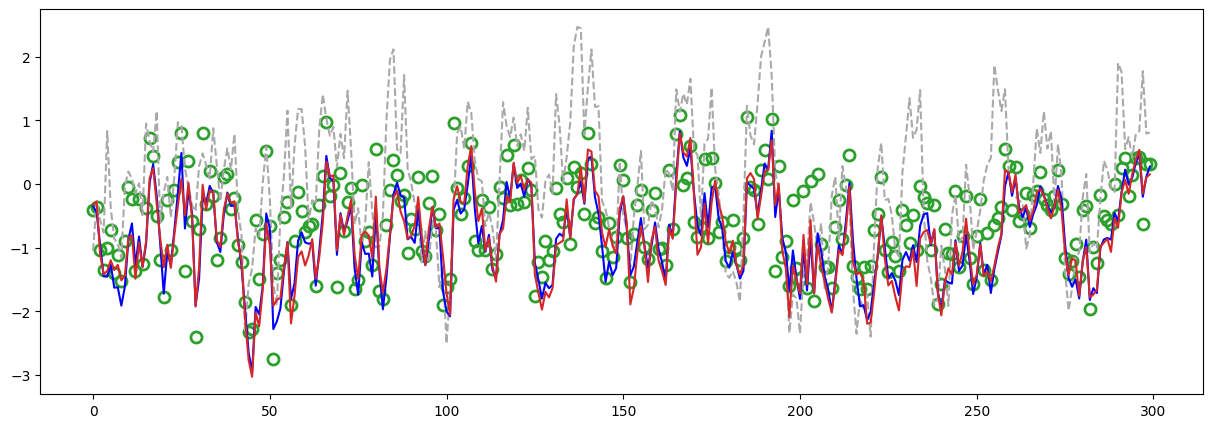




N: 100                                                                                                 
BPF particles shape:  (300, 100, 1)
BPF weights shape:  (300, 100)
BPF logZ_hat:  -718.9683227539062
BPF weighted x_t shape:  (300, 1)
MSE from BPF to exact filter means:  0.01379214


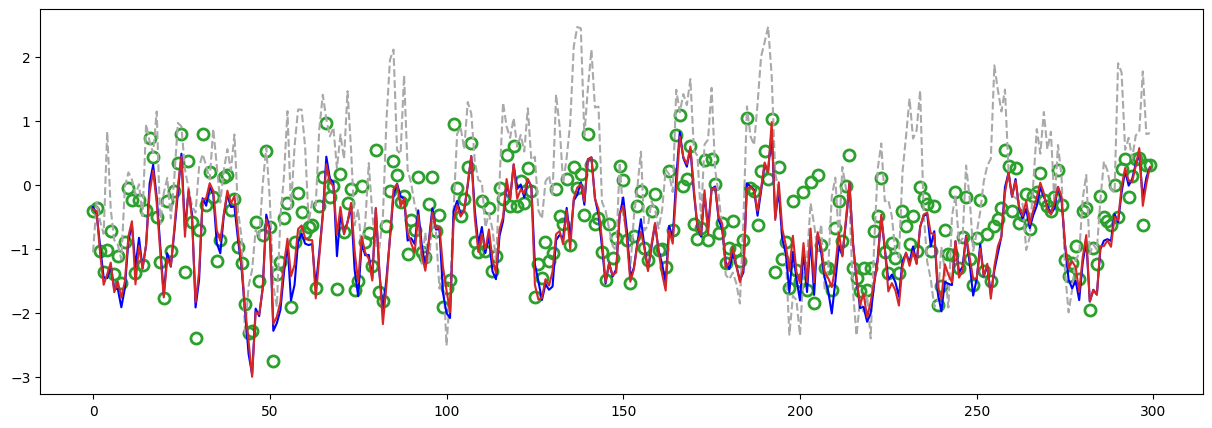




N: 1000                                                                                                
BPF particles shape:  (300, 1000, 1)
BPF weights shape:  (300, 1000)
BPF logZ_hat:  -718.5704345703125
BPF weighted x_t shape:  (300, 1)
MSE from BPF to exact filter means:  0.0015867938


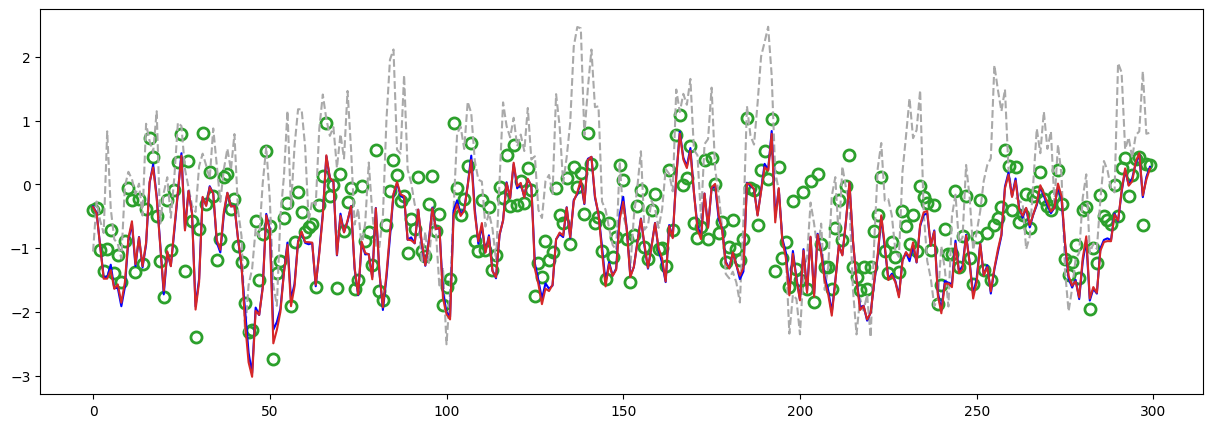

In [15]:
for N in [3, 10, 50, 100, 1000]:
    print(f"N: {N:<-100}")
    outs = bpf(data, N)
    
    # calculate weighted estimates of state means
    x_hat = jnp.sum(outs.weights[:, :, None] * outs.particles, axis=1)
    print("BPF weighted x_t shape: ", x_hat.shape)
    
    # calculate MSE against true filter means
    mse = jnp.mean((x_hat - lgssm_posterior.filtered_means)**2)
    print("MSE from BPF to exact filter means: ", mse)
    
    # plot results
    observation_marker_kwargs = {"marker": "o", "markerfacecolor": "none", "markeredgewidth": 2, "markersize": 8}
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(y, ls="", **observation_marker_kwargs, color="tab:green", label="observed")
    ax.plot(x, ls="--", color="darkgrey", label="true state")
    ax.plot(lgssm_posterior.filtered_means, color="blue", label="filtered mean")
    ax.plot(x_hat, color="tab:red", label="BPF estimate")
    plt.show()
    print("\n\n")